In [1]:
import os
from Utils.read_coord import kml_coord
from Utils.sentinal_request import senti_api
from Utils.forest_cover import get_cover
import numpy as np
import pandas as pd

from Utils.sentinal_request import senti_api


In [56]:
file_path = input('Enter kml file path: ')
print(file_path)

if os.path.exists(file_path):
    print('The file exists')

    with open(file_path, 'r', encoding='utf-8-sig') as f:
        lines = f.readlines()

        #print(lines)
else:
    print('The specified file does NOT exist')


Enter kml file path: C:\Users\User\Downloads\Cinnamon yala whole.kml
C:\Users\User\Downloads\Cinnamon yala whole.kml
The file exists


In [57]:
poly_coord = kml_coord(file_path)

In [58]:
img,resol = senti_api(poly_coord)


In [59]:

from sentinelhub import SHConfig

config = SHConfig()
#create an client and instance on sentinal-hub
config.sh_client_id = '1543b9e6-3abf-441b-9f19-0c8b70b925b2'
config.sh_client_secret = 'J2H.z_4ENpdQomb)Q1t*f-u?Zh<{)TH1Cd4JmQMv'
config.instance_id = "d6043a1f-543a-453e-acd6-8f90b6b74f56"
config.save()
if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
    
#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline

from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    Geometry,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)
#bounding box defining
def bbox_cord(poly):
    poly_arr = np.array(poly)
    df = pd.DataFrame(poly_arr, columns = ['lat','long'])
    Xmin = df['lat'].min()
    Ymin = df['long'].min()
    Xmax = df['lat'].max()
    Ymax = df['long'].max()
    bbox = [Xmin,Ymin,Xmax,Ymax]
    #i = [1,0]
    #output = poly_arr[:,i]
    #output = output.tolist()
    return bbox,poly



#date range
def date_range():
    current_date = datetime.today()
    past_date = datetime.today() - relativedelta(months=12)
    n_chunks = 12
    tdelta = (current_date - past_date) / n_chunks
    edges = [(past_date + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    return slots
    

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04","B08","CLM"],
                
            }],
            output: {
                bands: 5,
                sampleType: "float32"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B02, sample.B03, sample.B04,sample.B08,sample.CLM];
    }
"""
#32 bit Tiff output wuth 4 bands
def request_all_bands(time_interval,final_bbox,geometry,box_size):
    
    return  SentinelHubRequest(
        data_folder="Data", #data store directory
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=time_interval,
                mosaicking_order=MosaickingOrder.LEAST_CC,
                #other_args={"dataFilter": {"maxCloudCoverage": 20}},
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=final_bbox,
        size=box_size,
        geometry = geometry,
        config=config,
    )




# plotting
def plott(list_of_requests,slots,box_size):
    
    #best=np.count_nonzero(cloud_pix == 1) #initializing
    ##ncols = 3
    #nrows = 2
    #aspect_ratio = box_size[0] / box_size[1]
    #subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
    pos=0 #position
    best_slot=0
    #
    #fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)
    cloud_pix=list_of_requests[0][0]
    best=np.count_nonzero(cloud_pix == 1)
    for  idx, image in enumerate(list_of_requests):
        cloud_pix = image[0][:, :, 4]
        cloud = np.count_nonzero(cloud_pix == 1)
        if best >= cloud :
            best=cloud
            best_slot=slots[idx]
            pos = idx
    return pos

def senti (poly):
    #poly = [[7.090278,80.55444],[7.090278,80.55417],[7.090556,80.55222],[7.090278,80.55167],[7.09,80.55083],[7.091389,80.54806],[7.093056,80.55],[7.093333,80.55083],[7.094167,80.55306],[7.094167,80.55333],[7.093889,80.55417],[7.093611,80.555],[7.0925,80.55528],[7.091667,80.55528],[7.090833,80.555]]
    bbox_generated,poly = bbox_cord(poly)

    slots = date_range()

    #define diementions for the request
    final_bbox = BBox(bbox=bbox_generated, crs=CRS.WGS84)
    geometry = Geometry(geometry={"type":"Polygon","coordinates":[poly]}, crs=CRS.WGS84)

    #resolution and size of the output
    resolution =10
    box_size = bbox_to_dimensions(final_bbox, resolution= resolution)

    # create a list of requests
    list_of_requests = [request_all_bands(slot,final_bbox,geometry,box_size) for slot in slots]
    list_of_requests = [request.get_data() for request in list_of_requests]
    pos = plott(list_of_requests,slots,box_size)
    img = list_of_requests[pos][0][:, :, [0, 1, 2,3]]
    return img,slots,pos,final_bbox,geometry,box_size,list_of_requests

In [60]:
ret,slots,pos,final_bbox,geometry,box_size,list_of_requests = senti(poly_coord)

In [61]:
slot = slots[pos]

In [62]:
slot

('2022-09-28', '2022-10-28')

0 0 ('2021-10-28', '2021-11-27') (70, 77, 3)
1 0 ('2021-11-27', '2021-12-28') (70, 77, 3)
2 0 ('2021-12-28', '2022-01-27') (70, 77, 3)
3 0 ('2022-01-27', '2022-02-27') (70, 77, 3)
4 0 ('2022-02-27', '2022-03-29') (70, 77, 3)
5 0 ('2022-03-29', '2022-04-29') (70, 77, 3)
6 2824 ('2022-04-29', '2022-05-29') (70, 77, 3)
7 0 ('2022-05-29', '2022-06-28') (70, 77, 3)
8 99 ('2022-06-28', '2022-07-29') (70, 77, 3)
9 0 ('2022-07-29', '2022-08-28') (70, 77, 3)
10 0 ('2022-08-28', '2022-09-28') (70, 77, 3)
11 0 ('2022-09-28', '2022-10-28') (70, 77, 3)
0 11


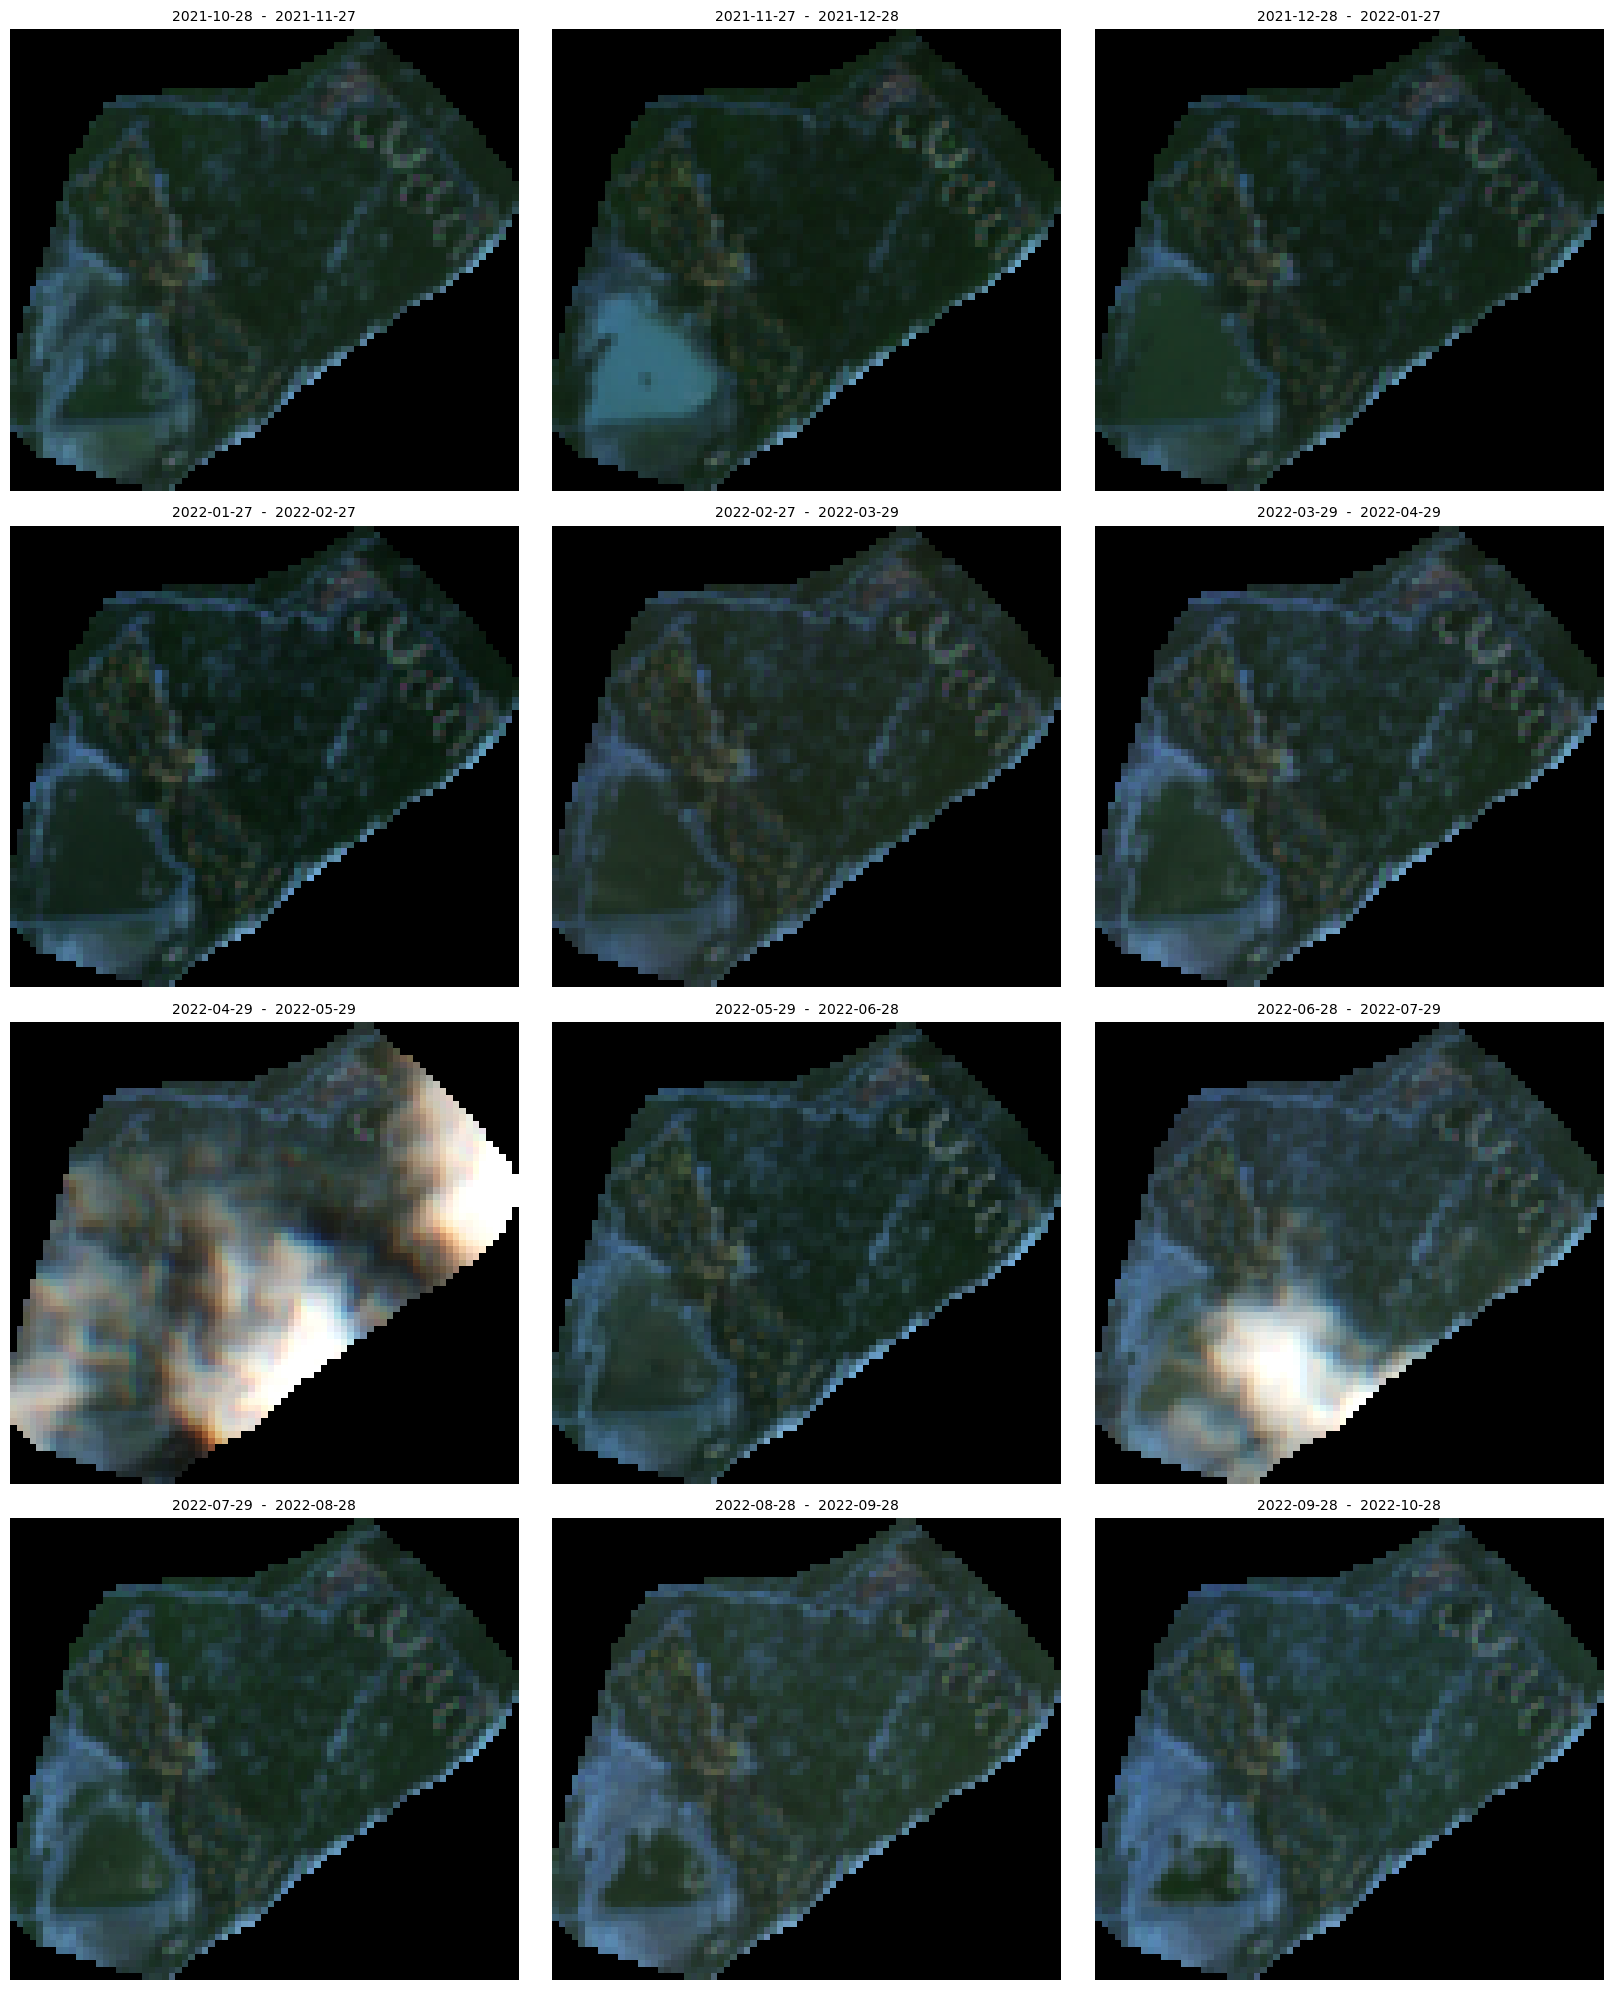

In [63]:
# plotting
# cloud_pix=list_of_requests[0][0]
# best=np.count_nonzero(cloud_pix == 1) #initializing
ncols = 3
nrows = 4
aspect_ratio = box_size[0] / box_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}
pos=0 #position
best_slot=0
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)
cloud_pix=list_of_requests[0][0]
best=np.count_nonzero(cloud_pix == 1)
for  idx, image in enumerate(list_of_requests):
    imagex = image[0][:, :, [0,1, 2]]
    cloud_pix = image[0][:, :, 4]
    cloud = np.count_nonzero(cloud_pix == 1)
    if best >= cloud :
        best=cloud
        best_slot=slots[idx]
        pos = idx
    print(idx,cloud,slots[idx],imagex.shape)
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(imagex * 2.5 , 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)
plt.tight_layout()
print(best,pos)

In [64]:
cloud_pix=list_of_requests[5][0][:, :, 4]
cloud_pix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [65]:
cloud = np.count_nonzero(cloud_pix == 1)
cloud

0

In [66]:
from utils import plot_image

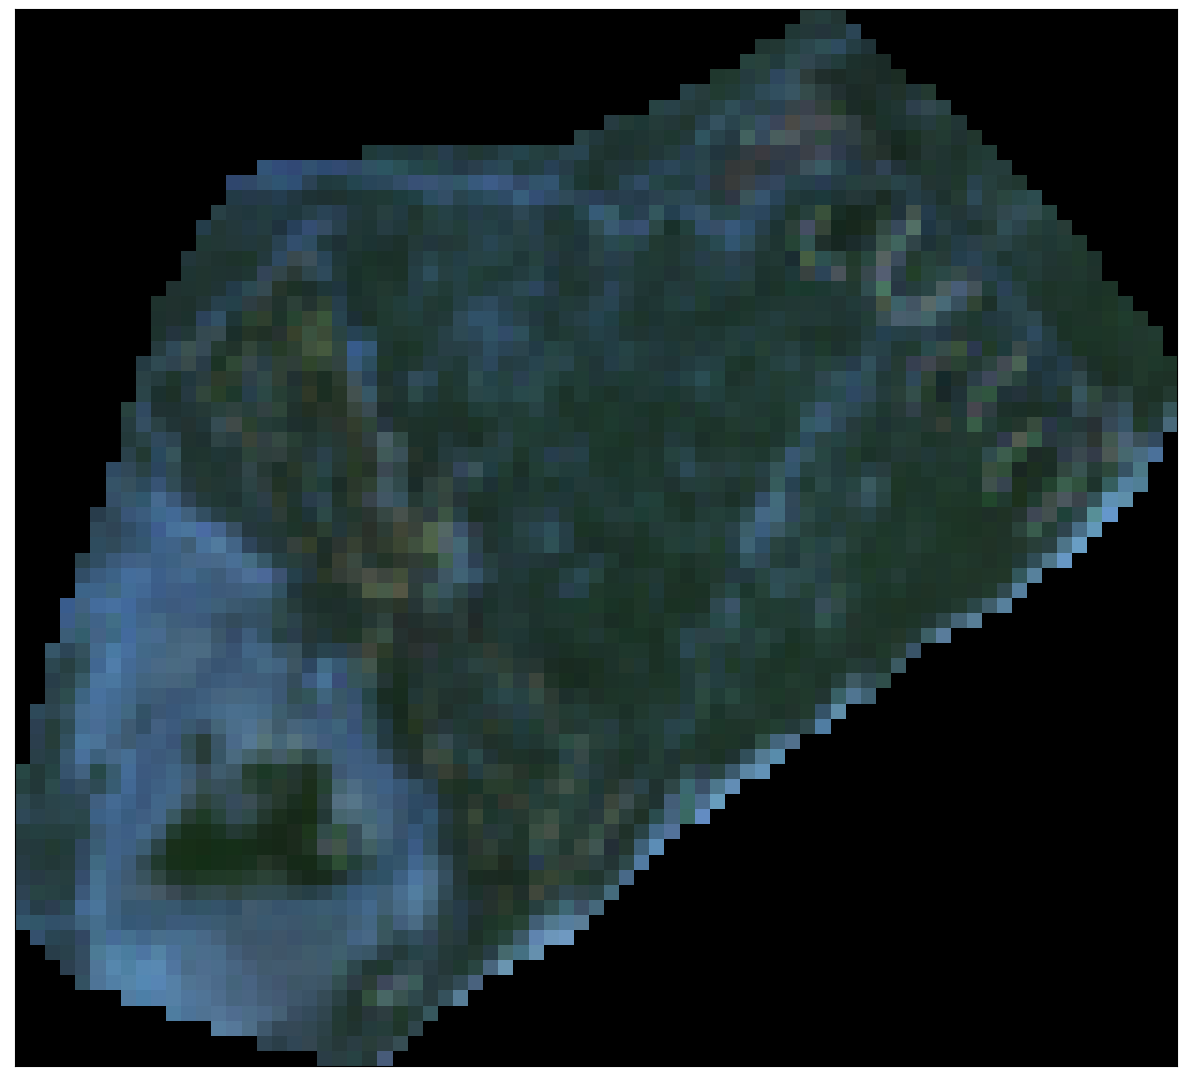

In [67]:
plot_image(list_of_requests[pos][0][:, :, [0, 1, 2]], factor=2.5, clip_range=(0, 1))

In [68]:
slot = ('2021-04-25', '2022-10-25')

In [69]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B08","B02","B03","B04"],
                units: "DN"
            }],
            output: {
                bands: 4,
                sampleType: "float32" 
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08,
                sample.B02,
                sample.B03,
                sample.B04,
];
    }
"""
#32 bit Tiff output wuth 4 bands
request_all_bands = SentinelHubRequest(
    data_folder="Data", #data store directory
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=(slot),
            mosaicking_order=MosaickingOrder.LEAST_CC,
            other_args={"dataFilter": {"maxCloudCoverage": 20}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=final_bbox,
    size=box_size,
    geometry = geometry,
    config=config,
)

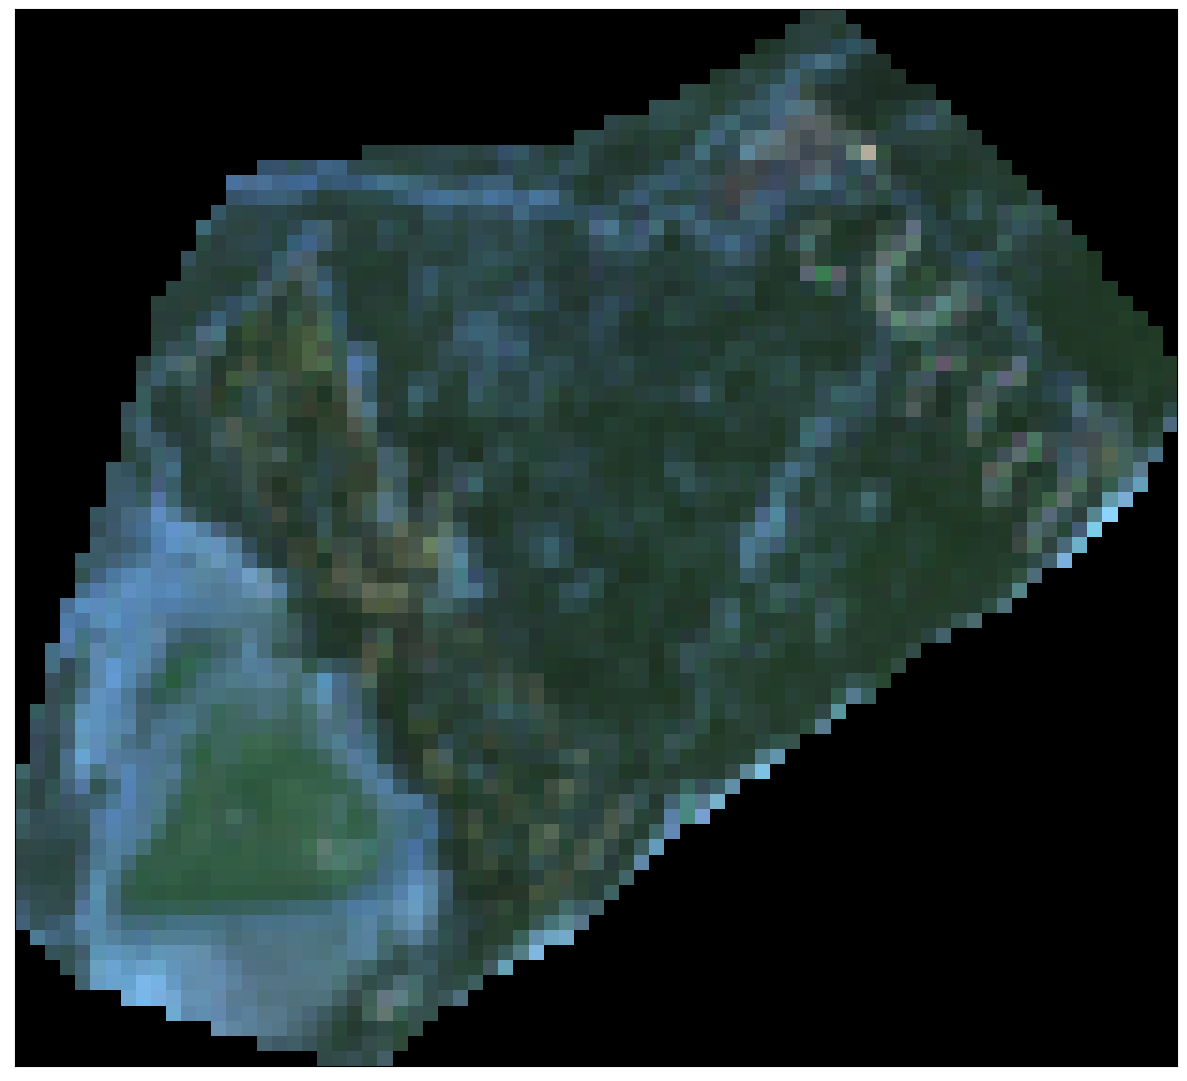

In [70]:
all_bands_response = request_all_bands.get_data()
plot_image(all_bands_response[0][:, :, [1, 2, 3]], factor=3.5 / 1e4, clip_range=(0, 1))